In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
from textwrap import wrap
from scipy.stats import wilcoxon

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
# from task import *
from functions import *
# from train import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Supplementary figure 7b: example sensorimotor neurons with conjunctive selectivity

dend_nonlinearity divisive_2
sparse_srsst_to_sredend 0
initialization_weights kaiming_normal
activation relu


/home/yl4317/Documents/two_module_rnn/code/functions.py:2588: RuntimeWarning: invalid value encountered in divide
  rule_sel_across_time[n] = (act_rule1_time - act_rule2_time)/(np.abs(act_rule1_time) + np.abs(act_rule2_time))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_fdbk = (act_rule1_fdbk - act_rule2_fdbk)/(np.abs(act_rule1_fdbk) + np.abs(act_rule2_fdbk))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_iti = (act_rule1_iti - act_rule2_iti)/(np.abs(act_rule1_iti) + np.abs(act_rule2_iti))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_ref_card = (act_rule1_ref_card - act_rule2_ref_card)/(np.abs(act_rule1_ref_card) + np.abs(act_rule2_ref_card))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2610: RuntimeWarning: invalid valu

n=27, preferred rule=2, choice=3, ref_card=(0, 0)


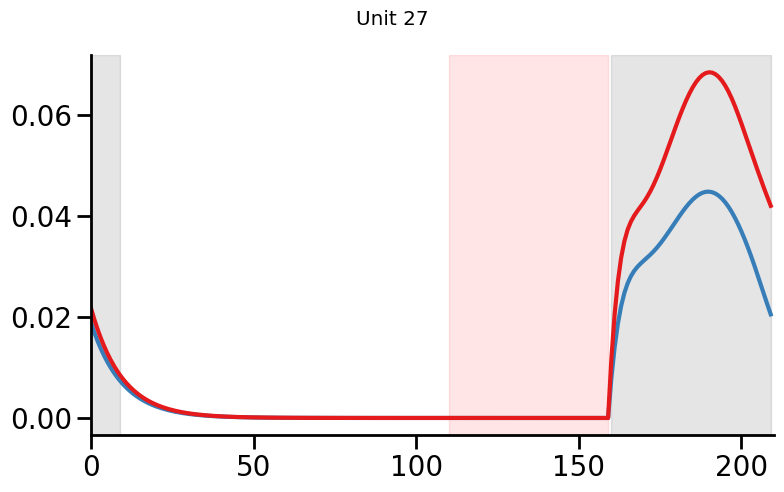

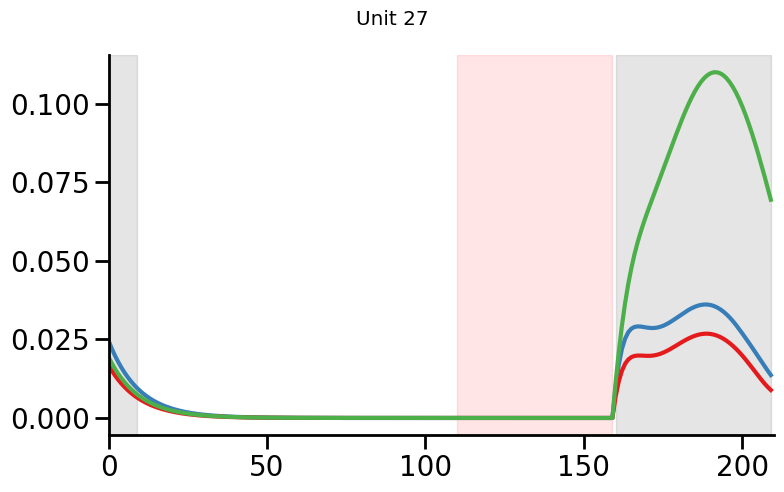

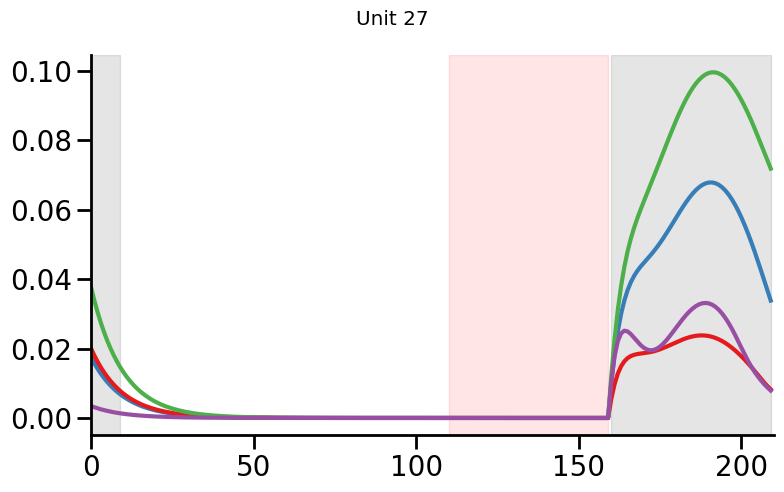

In [4]:
# plot the activity of conjunctive cells

n_total_fs = 4    # number of total features per card
n_test_cards = 3
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3']

data_suppfig7b_rule = {'rule1': [], 'rule2': []}
data_suppfig7b_resp = {'c1': [], 'c2': []}
data_suppfig7b_sharedFeature = {'blue': [], 'red': [], 'circle': [], 'triangle': []}

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'success' in model_name:
        # print(model_name+'\n')
        if model_name != 'success_2023-05-10-14-28-42_wcst_105_sparsity0':    # the example model shown in the paper
            continue
        
#         # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        # add filter
        if hp_test['dt']!=10:
            continue
        if len(hp_test['cell_group_list'])==2:
            print('pass\n')
            continue
        
        for key in ['dend_nonlinearity', 'sparse_srsst_to_sredend', 'initialization_weights', 'activation']:
            print(key, hp_test[key])

        # generate some neural data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        current_matrix = neural_data['current_matrix']
        
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        trs_by_center_card = trial_labels['trs_by_center_card_stable']
        
        
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                    rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                    rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
                                    resp_trs_stable = resp_trs_stable, trs_by_center_card=trs_by_center_card,
                                    stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        resp_sel_normalized = all_sels['resp_normalized']
        rule_sel_normalized = all_sels['rule_normalized_activity']
        error_sel_normalized = all_sels['error_normalized']
        ref_card_sel_normalized = all_sels['ref_card_normalized']
        
        # define subpopulations
        subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                              rule_sel=rule_sel_normalized, resp_sel=resp_sel_normalized, ref_card_sel=ref_card_sel_normalized,
                                              rule1_trs_stable=rule1_trs_stable, 
                                              rule2_trs_stable=rule2_trs_stable, 
                                              rule_threshold=0, resp_threshold=0)
        for subcg in subcg_sr_idx.keys():
            model.rnn.cg_idx['subcg_sr_'+subcg] = subcg_sr_idx[subcg]


        
        #=== analysis ===#
        for n in model.rnn.cg_idx['sr_esoma']:
            if n != 27:
                continue
            if n in subcg_sr_idx['silent_sr_esoma']:
                continue
            else:
                for rule in ['1', '2']:
                    if n in subcg_sr_idx['rule{}_sr_esoma'.format(rule)]:
                        preferred_rule = rule
                for choice in ['1', '2', '3']:
                    if n in subcg_sr_idx['respc{}_sr_esoma'.format(choice)]:
                        preferred_choice = choice
                for ref_card in [(0,0), (1,0), (0,1), (1,1)]:
                    if n in subcg_sr_idx['ref_card{}_sr_esoma'.format(ref_card)]:
                        preferred_refcard = ref_card
            print('n={}, preferred rule={}, choice={}, ref_card={}'.format(n, preferred_rule, preferred_choice, preferred_refcard))
            preferred_rule_trs = trial_labels['rule{}_trs_stable'.format(preferred_rule)]
            preferred_choice_trs = trial_labels['c{}_trs_stable'.format(preferred_choice)] 
            preferred_ref_card_trs = trial_labels['trs_by_center_card_stable'][preferred_refcard]
            trs_high_activity = [tr for tr in range(rnn_activity.shape[0]) if tr in preferred_rule_trs and tr in preferred_choice_trs and tr in preferred_ref_card_trs]
            trs_low_activity = [tr for tr in range(rnn_activity.shape[0]) if tr not in trs_high_activity]

            # plot single trial activity (not shown in the paper)
            # fig, ax = plt.subplots(1, 4, figsize=[20, 3])
            # fig.suptitle(n)
            # fig.patch.set_facecolor('white')
            # for tr in range(rnn_activity.shape[0]):
            #     if tr in trial_labels['rule1_trs_stable']:
            #         color_rule = 'blue'
            #     elif tr in trial_labels['rule2_trs_stable']:
            #         color_rule = 'red'
                    
            #     if tr in trial_labels['c1_trs_stable']:
            #         color_choice = 'blue'
            #     elif tr in trial_labels['c2_trs_stable']:
            #         color_choice = 'red'
            #     elif tr in trial_labels['c3_trs_stable']:
            #         color_choice = 'green'
                    
            #     if tr in trial_labels['trs_by_center_card_stable'][(0,0)]:
            #         color_refcard = 'blue'
            #     elif tr in trial_labels['trs_by_center_card_stable'][(0,1)]:
            #         color_refcard = 'red'
            #     elif tr in trial_labels['trs_by_center_card_stable'][(1,0)]:
            #         color_refcard = 'green' 
            #     elif tr in trial_labels['trs_by_center_card_stable'][(1,1)]:
            #         color_refcard = 'yellow'
                    
            #     ax[0].plot(rnn_activity[tr, :, 0, n], color=color_rule)
            #     ax[1].plot(rnn_activity[tr, :, 0, n], color=color_choice)
            #     ax[2].plot(rnn_activity[tr, :, 0, n], color=color_refcard)
                
            # for tr in trs_high_activity:
            #     ax[3].plot(rnn_activity[tr, :, 0, n], color='red')
            # for tr in trs_low_activity:
            #     ax[3].plot(rnn_activity[tr, :, 0, n], color='k')
            # fig.tight_layout()
            # plt.show()
            
            
            # plot  trial-averaged activity

            # according to rule
            fig, ax = plt.subplots(1, 1, figsize=[8, 5])
            fig.suptitle('Unit {}'.format(n))
            fig.patch.set_facecolor('white')
            ax.plot(np.mean(rnn_activity[trial_labels['rule1_trs_stable'], :, 0, n], axis=0), linewidth=3, color=colors[0], label='color rule')
            ax.plot(np.mean(rnn_activity[trial_labels['rule2_trs_stable'], :, 0, n], axis=0), linewidth=3, color=colors[1], label='shape rule')
            # ax.legend(bbox_to_anchor=(1.3, 1.4), prop={'size': 10})
            ax.set_xlim([0, 210])
            make_pretty_axes(ax)
            plot_task_epochs(hp_task=hp_task_test, hp=hp_test, ax=ax)
            fig.tight_layout()
            plt.show()
            fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/example_conjunctive_unit_sortByRule.pdf')
            data_suppfig7b_rule['rule1'] = np.mean(rnn_activity[trial_labels['rule1_trs_stable'], :, 0, n], axis=0)
            data_suppfig7b_rule['rule2'] = np.mean(rnn_activity[trial_labels['rule2_trs_stable'], :, 0, n], axis=0)
            

            # according to response
            fig, ax = plt.subplots(1, 1, figsize=[8, 5])
            fig.suptitle('Unit {}'.format(n))
            fig.patch.set_facecolor('white')
            ax.plot(np.mean(rnn_activity[trial_labels['c1_trs_stable'], :, 0, n], axis=0), linewidth=3, color=colors[0], label='location 1')
            ax.plot(np.mean(rnn_activity[trial_labels['c2_trs_stable'], :, 0, n], axis=0), linewidth=3, color=colors[1], label='location 2')
            ax.plot(np.mean(rnn_activity[trial_labels['c3_trs_stable'], :, 0, n], axis=0), linewidth=3, color=colors[2], label='location 3')
            # ax.legend(bbox_to_anchor=(1.3, 1.4), prop={'size': 10})
            ax.set_xlim([0, 210])
            make_pretty_axes(ax)
            plot_task_epochs(hp_task=hp_task_test, hp=hp_test, ax=ax)
            fig.tight_layout()
            plt.show()
            fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/example_conjunctive_unit_sortByResp.pdf')
            data_suppfig7b_resp['c1'] = np.mean(rnn_activity[trial_labels['c1_trs_stable'], :, 0, n], axis=0)
            data_suppfig7b_resp['c2'] = np.mean(rnn_activity[trial_labels['c2_trs_stable'], :, 0, n], axis=0)
            data_suppfig7b_resp['c3'] = np.mean(rnn_activity[trial_labels['c3_trs_stable'], :, 0, n], axis=0)
            

            # according to shared feature
            # further divide rule1/2 trials into the shared feature
            blue_trials = [tr for tr in rule1_trs_stable if (tr in trial_labels['trs_by_center_card_stable'][(0,0)] or tr in trial_labels['trs_by_center_card_stable'][(0,1)])]
            red_trials = [tr for tr in rule1_trs_stable if (tr in trial_labels['trs_by_center_card_stable'][(1,0)] or tr in trial_labels['trs_by_center_card_stable'][(1,1)])]
            circle_trials = [tr for tr in rule2_trs_stable if (tr in trial_labels['trs_by_center_card_stable'][(0,0)] or tr in trial_labels['trs_by_center_card_stable'][(1,0)])]
            triangle_trials = [tr for tr in rule2_trs_stable if (tr in trial_labels['trs_by_center_card_stable'][(0,1)] or tr in trial_labels['trs_by_center_card_stable'][(1,1)])]
            
            fig, ax = plt.subplots(1, 1, figsize=[8, 5])
            fig.suptitle('Unit {}'.format(n))
            fig.patch.set_facecolor('white')
            ax.plot(np.mean(rnn_activity[blue_trials, :, 0, n], axis=0), color=colors[0], linewidth=3, label='shared feature = blue')
            ax.plot(np.mean(rnn_activity[red_trials, :, 0, n], axis=0), color=colors[1], linewidth=3, label='shared feature = red')
            ax.plot(np.mean(rnn_activity[circle_trials, :, 0, n], axis=0), color=colors[2], linewidth=3, label='shared feature = circle')
            ax.plot(np.mean(rnn_activity[triangle_trials, :, 0, n], axis=0), color=colors[3], linewidth=3, label='shared feature = triangle')
            # ax.legend(bbox_to_anchor=(1.3, 1.4), prop={'size': 10})
            ax.set_xlim([0, 210])
            make_pretty_axes(ax)
            plot_task_epochs(hp_task=hp_task_test, hp=hp_test, ax=ax)
            fig.tight_layout()
            plt.show()
            fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/example_conjunctive_unit_sortBySharedFeature.pdf')
            data_suppfig7b_sharedFeature['blue'] = np.mean(rnn_activity[blue_trials, :, 0, n], axis=0)
            data_suppfig7b_sharedFeature['red'] = np.mean(rnn_activity[red_trials, :, 0, n], axis=0)
            data_suppfig7b_sharedFeature['circle'] = np.mean(rnn_activity[circle_trials, :, 0, n], axis=0)
            data_suppfig7b_sharedFeature['triangle'] = np.mean(rnn_activity[triangle_trials, :, 0, n], axis=0)

# pd.DataFrame.from_dict(data=data_suppfig7b_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig7b_example_conjUnit_rule.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig7b_resp, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig7b_example_conjUnit_resp.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig7b_sharedFeature, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig7b_example_conjUnit_sharedFeature.csv', header=False)

# Supplementary Figure 7a: Joint distribution of selectivity indices for different task variables

## Generate data

In [25]:
# compute selectivity

start = time.time()

plt.rc('font', size=12)

all_data_sm_rule_resp_sel = []

for model_name in os.listdir('/scratch/yl4317/two_module_rnn/saved_models/'):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
#     if ('2022-10-24' in model_name) and 'success' in model_name:
#     if 'full_model' in model_name and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        # add filters here
#         if hp_test['dt']!=10:
#             print('pass\n')
#             continue
#         if len(hp_test['cell_group_list'])==2:
#             print('pass\n')
#             continue
            
        # make noiseless
#         model.rnn.network_noise = 0
#         hp_test['input_noise_perceptual'] = 0
#         hp_test['input_noise_rule'] = 0
        
        # generate some neural data
#         neural_data = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, to_plot=False, hp_test=hp_test, hp_task_test=hp_task_test, compute_current=False)
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data = pickle.load(f)
#         neural_data_all_models[model_name] = neural_data
        test_data = neural_data['test_data']
        mean_perf = np.mean(test_data['perfs'])
        if mean_perf <= 0.8:
            print('low performance ({}), pass\n'.format(mean_perf))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
#         current_matrix = neural_data['current_matrix']
        
        
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
#         trial_labels_all_models[model_name] = trial_labels
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=np.asarray(test_data['rules']),
                                         rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                         rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
                                         resp_trs_stable = resp_trs_stable, trs_by_center_card = trial_labels['trs_by_center_card_stable'],
                                         stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
#         resp_sel_normalized = all_sels['resp_normalized']
#         rule_sel_normalized = all_sels['rule_normalized_activity']

        # define subpopulations
        subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], 
                                          ref_card_sel=all_sels['ref_card_normalized'],
                                          rule1_trs_stable=rule1_trs_stable, 
                                          rule2_trs_stable=rule2_trs_stable, 
                                          rule_threshold=0, resp_threshold=0)
        
#         subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
#                                           rule_sel=all_sels['rule_normalized_activity'], err_sel=all_sels['error_normalized'], 
#                                           rule1_trs_stable=rule1_trs_stable, 
#                                           rule2_trs_stable=rule2_trs_stable, 
#                                           rule1_after_error_trs=trial_labels['rule1_trs_after_error'],
#                                           rule2_after_error_trs=trial_labels['rule2_trs_after_error'],
#                                           rule_threshold=0.5, err_threshold=0.5)
        
        #=== analysis ===#
#         fig, ax=plt.subplots(1, 3, figsize=[18,5])
#         fig.patch.set_facecolor('white')
#         plt.style.use('classic')
#         title = fig.suptitle('SR Esoma' + '\n' + '\n'.join(wrap(model_name, 60)))
#         rule_sel_sresoma = [rule_sel_normalized[n] for n in model.rnn.cg_idx['sr_esoma']]
#         c = 0
#         for resp in ['c1', 'c2', 'c3']:
#             c += 1
#             resp_sel_sresoma_c = [resp_sel_normalized[n][resp] for n in model.rnn.cg_idx['sr_esoma']]
#             ax[c-1].scatter(x=rule_sel_sresoma, y=resp_sel_sresoma_c, color = 'k', alpha=0.5)
#             ax[c-1].set_xlabel('rule selectivity')
#             ax[c-1].set_ylabel('response selectivity for {}'.format(resp))
#         fig.tight_layout()
#         plt.show()
        
    
#         is_rule_cell = np.zeros(model.rnn.total_n_neurons)
#         for cg in model.rnn.cell_group_list:
#             for n in model.rnn.cg_idx[cg]:
#                 if 'sr' in cg:
#                     if n in subcg_sr_idx['rule1_'+cg] or n in subcg_sr_idx['rule2_'+cg]:
#                         is_rule_cell[n] = True
#                     else:
#                         is_rule_cell[n] = False
#                 elif 'pfc' in cg:
#                     if n in subcg_pfc_idx['rule1_'+cg] or n in subcg_pfc_idx['rule2_'+cg]:
#                         is_rule_cell[n] = True
#                     else:
#                         is_rule_cell[n] = False

#         for cg in model.rnn.cell_group_list:
#             if 'sr' in cg:
#                 rule_sel_subselect_rule_cells.append([all_sels['rule_activity'][n] for n in model.rnn.cg_idx[cg] if (n in subcg_sr_idx['rule1_{}'.format(cg.replace('sr_', ''))] or n in x['subcg_sr_idx']['rule2_{}'.format(cg.replace('sr_', ''))])])
#             elif 'pfc' in cg:
#                 rule_sel_subselect_rule_cells.append([all_sels['rule_activity'][n] for n in model.rnn.cg_idx[cg] if (n in subcg_pfc_idx['rule1_{}'.format(cg.replace('pfc_', ''))] or n in subcg_pfc_idx['rule2_{}'.format(cg.replace('pfc_', ''))])])
                
        all_data_sm_rule_resp_sel.append({'cg_idx': model.rnn.cg_idx, 'model_name': model_name, 'hp': hp_test, 'cell_group_list': model.rnn.cell_group_list,
                                          'rule_sel': all_sels['rule_activity'], 
                                          'rule_sel_roc': all_sels['rule_sel_roc'],
                                          'rule_sel_norm': all_sels['rule_normalized_activity'],
#                                           'is_rule_cell': is_rule_cell,
                                          'resp_sel': all_sels['resp'],
                                          'resp_sel_norm': all_sels['resp_normalized'],
                                          'mean_act': np.mean(rnn_activity, axis=(0, 1, 2)),
#                                           'n_rule_sel_sm_edends': len(subcg_sr_idx['rule1_sr_edend']) + len(subcg_sr_idx['rule2_sr_edend']),
                                          'subcg_sr_idx': subcg_sr_idx,
                                          'all_sels': all_sels
#                                           'rule_sel_sresoma_norm': [rule_sel_normalized[n] for n in model.rnn.cg_idx['sr_esoma']],
#                                           'resp_sel_sresoma_norm': [resp_sel_normalized[n] for n in model.rnn.cg_idx['sr_esoma']],
#                                           'rule_sel_sresoma': [all_sels['rule_activity'][n] for n in model.rnn.cg_idx['sr_esoma']],
#                                           'resp_sel_sresoma': [all_sels['resp'][n] for n in model.rnn.cg_idx['sr_esoma']],
#                                           'rule_sel_srpv_norm': [rule_sel_normalized[n] for n in model.rnn.cg_idx['sr_pv']],
#                                           'resp_sel_srpv_norm': [resp_sel_normalized[n] for n in model.rnn.cg_idx['sr_pv']],
#                                           'rule_sel_srpv': [all_sels['rule_activity'][n] for n in model.rnn.cg_idx['sr_pv']],
#                                           'resp_sel_srpv': [all_sels['resp'][n] for n in model.rnn.cg_idx['sr_pv']]
                                         })

with open('/home/yl4317/Documents/two_module_rnn/processed_data/rule_selectivity_distribution.pickle', 'wb') as f:
    pickle.dump(all_data_sm_rule_resp_sel, f)
print(time.time()-start)

success_2023-05-10-14-28-42_wcst_44_sparsity0
success_2023-05-10-14-28-42_wcst_93_sparsity0
success_2023-05-10-14-28-42_wcst_6_sparsity0
success_2023-05-10-14-28-42_wcst_60_sparsity0
success_2023-05-10-14-28-42_wcst_106_sparsity0
success_2023-05-10-14-28-42_wcst_150_sparsity0
low performance (0.0), pass

success_2023-05-10-14-28-42_wcst_21_sparsity0
success_2023-05-10-14-28-42_wcst_183_sparsity0
low performance (0.0), pass

success_2023-05-10-14-28-42_wcst_58_sparsity0
success_2023-05-10-14-28-42_wcst_136_sparsity0
success_2023-05-10-14-28-42_wcst_142_sparsity0
success_2023-05-10-14-28-42_wcst_7_sparsity0
success_2023-05-10-14-28-42_wcst_18_sparsity0
success_2023-05-10-14-28-42_wcst_134_sparsity0
success_2023-05-10-14-28-42_wcst_20_sparsity0
success_2023-05-10-14-28-42_wcst_50_sparsity0
success_2023-05-10-14-28-42_wcst_151_sparsity0
success_2023-05-10-14-28-42_wcst_172_sparsity0
low performance (0.0), pass

success_2023-05-10-14-28-42_wcst_126_sparsity0
success_2023-05-10-14-28-42_wcst

# Supplementary Figure 7a: rule selectivity distribution across cell types

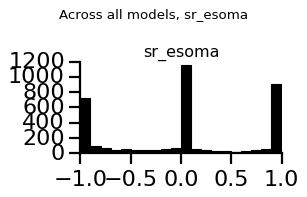

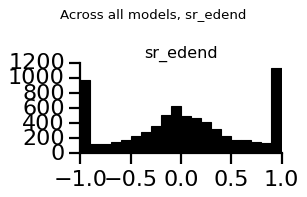

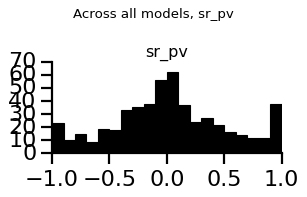

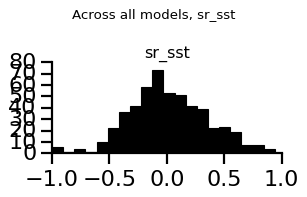

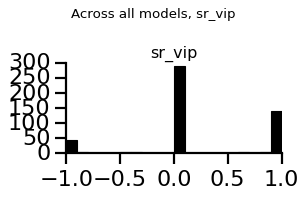

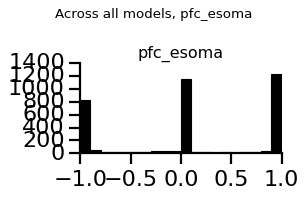

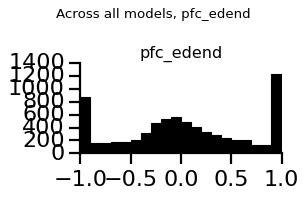

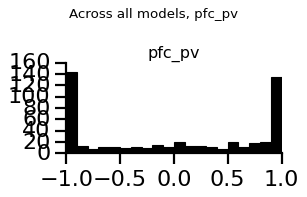

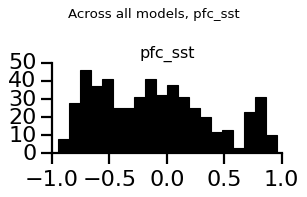

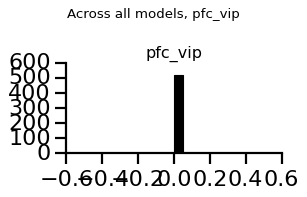

In [37]:
# rule selectivity distribution 
with open('/home/yl4317/Documents/two_module_rnn/processed_data/rule_selectivity_distribution.pickle', 'rb') as handle:
    all_data_sm_rule_resp_sel = pickle.load(handle)
cgs = model.rnn.cell_group_list

rule_sel_across_models = {}
for cg in cgs:
    rule_sel_across_models[cg] = []
for x in all_data_sm_rule_resp_sel: 
    for cg in cgs:
        rule_sels = [x['all_sels']['rule_normalized_activity'][n] for n in model.rnn.cg_idx[cg]]
        rule_sel_across_models[cg].extend(rule_sels)
    fig.tight_layout()
    plt.show()


for cg in cgs:
    fig, ax=plt.subplots(1, 1, figsize=[4, 2.5])
    fig.patch.set_facecolor('white')
    fig.suptitle('Across all models, {}'.format(cg))
    ax.set_title(cg)
    ax.hist(rule_sel_across_models[cg], color='k', bins=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/rule_sel_dist_{}.pdf'.format(cg))


# source data
data_suppfig7a_rule_sel_dist = rule_sel_across_models
pd.DataFrame.from_dict(data=data_suppfig7a_rule_sel_dist, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig7a_rule_sel_dist.csv', header=False)

# Figure 5b joint distribution of rule, response and shared feature selectivity

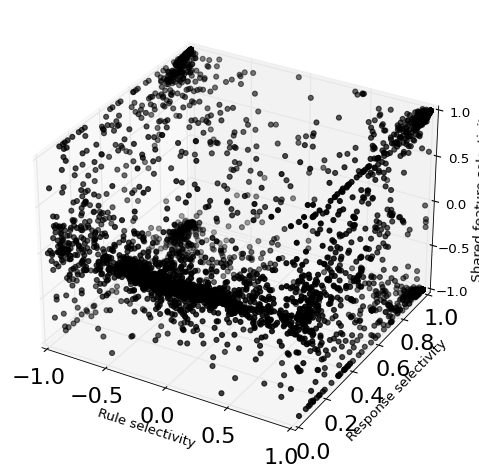

In [42]:
# rule selectivity x response selectivity x feature selectivity across all models

rule_sel_all = []
resp_sel_all = []
feature_sel_all = []

cg_idx = model.rnn.cg_idx['sr_esoma'].tolist() + model.rnn.cg_idx['sr_pv'].tolist() + model.rnn.cg_idx['sr_sst'].tolist() + model.rnn.cg_idx['sr_vip'].tolist()

for x in all_data_sm_rule_resp_sel:
    rule_sel_all.extend(x['all_sels']['rule_normalized_activity'][n] for n in cg_idx)
    resp_sel_all.extend(x['all_sels']['resp_normalized'][n]['max'] for n in cg_idx)
    feature_sel_all.extend(x['all_sels']['common_feature'][n] for n in cg_idx)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor('white')
ax.scatter(xs=np.array(rule_sel_all), ys=np.array(resp_sel_all), zs=np.array(feature_sel_all), color='k')  
ax.set_xlabel('Rule selectivity')
ax.set_ylabel('Response selectivity')
ax.set_zlabel('Shared feature selectivity')
ax.set_xlim([-1, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-1, 1])
make_pretty_axes(ax)
fig.tight_layout()
plt.show()
fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/joint_distribution_rule_resp_sharedFeature.pdf')

data_fig5b = {'x': rule_sel_all, 'y': resp_sel_all, 'z': feature_sel_all}
pd.DataFrame.from_dict(data=data_fig5b, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig5b_joint_distribution.csv', header=False)